In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
combined_stats = pd.read_csv('Data/FantasyCombined - One.csv')

In [5]:
combined_stats.head()

,AvgOvRank,Player,Tm,FantPos,2023Age,2023G,2023GS,2023Cmp,2023Att,PassYds,...,2024RushTD,2024Rec,2024RecYds,2024RecTD,2024FL,2024TD,2024PPR,AVGPPR,2024PosRank,AvgOvRank.1
0,1,Josh Allen,BUF,QB,27,17,17,385,579,4306,...,9,0.0,0,0.0,4,37,360.0,377,1,1
1,2,Christian McCaffrey,SFO,RB,27,16,16,0,0,0,...,12,70.0,568,5.0,2,16,351.0,371,1,2
2,3,CeeDee Lamb,DAL,WR,24,17,17,0,0,0,...,1,116.0,"1,488",10.0,1,11,333.0,368,1,3
3,4,Jalen Hurts,PHI,QB,25,17,17,352,538,3858,...,11,0.0,0,0.0,4,36,360.0,359,2,4
4,5,Tyreek Hill,MIA,WR,29,16,16,0,0,0,...,0,110.0,"1,542",10.0,1,10,325.0,351,2,5


In [7]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AvgOvRank    241 non-null    int64  
 1   Player       241 non-null    object 
 2   Tm           241 non-null    object 
 3   FantPos      241 non-null    object 
 4   2023Age      241 non-null    int64  
 5   2023G        241 non-null    int64  
 6   2023GS       241 non-null    int64  
 7   2023Cmp      241 non-null    int64  
 8   2023Att      241 non-null    int64  
 9   PassYds      241 non-null    int64  
 10  2023PassTD   241 non-null    int64  
 11  2023Int      241 non-null    int64  
 12  2023RushAtt  241 non-null    int64  
 13  2023RushYds  241 non-null    int64  
 14  2023RushTD   241 non-null    int64  
 15  2023Tgt      241 non-null    int64  
 16  2023Rec      241 non-null    int64  
 17  2023RecYds   241 non-null    int64  
 18  2023RecTD    241 non-null    int64  
 19  2023FL  

In [9]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [11]:
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

## Evaluate date using Train, Test, and Split

In [28]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features]
    y = position_data['AVGPPR']

 # Fill missing values with 0 for simplicity
    X = X.fillna(0)
    y = y.fillna(0)

# Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add labels to indicate training or testing data
    position_data.loc[X_train.index, 'Data Split'] = 'Train'
    position_data.loc[X_test.index, 'Data Split'] = 'Test'
    
    # Train the model with adjusted parameters
    rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = rf.predict(X)
    
    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', 'AVGPPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023Age', '2024Age', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
wr_features = ['2023Age', '2024Age', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
te_features = ['2023Age', '2024Age', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
qb_features = ['2023Age', '2024Age', 'PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', '2024TD']

# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions])

# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/CombinedFantasyFootballPrediction.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', 'AVGPPR']].to_csv(output_path, index=False)


RB - Training MAE: 4.746249999999999
RB - Testing MAE: 22.74366666666667

RB - Feature Importances:
        Feature  Importance
18       2024TD    0.448014
11  2024RushAtt    0.163746
3   2023RushYds    0.106410
12  2024RushYds    0.067795
13   2024RushTD    0.043352
14      2024Rec    0.042881
15   2024RecYds    0.033958
5       2023Rec    0.026183
4    2023RushTD    0.018264
9        2023TD    0.017686
2   2023RushAtt    0.015206
6     2023RecTD    0.004617
16    2024RecTD    0.003612
7         2023G    0.002589
0       2023Age    0.001736
1       2024Age    0.001588
8        2023FL    0.001358
17       2024FL    0.000514
10        2024G    0.000492

WR - Training MAE: 4.8112162162162155
WR - Testing MAE: 17.45447368421053

WR - Feature Importances:
        Feature  Importance
14      2024Rec    0.810579
5       2023Rec    0.062086
15   2024RecYds    0.035143
18       2024TD    0.029645
9        2023TD    0.008733
6     2023RecTD    0.008499
16    2024RecTD    0.008007
2   2023RushA

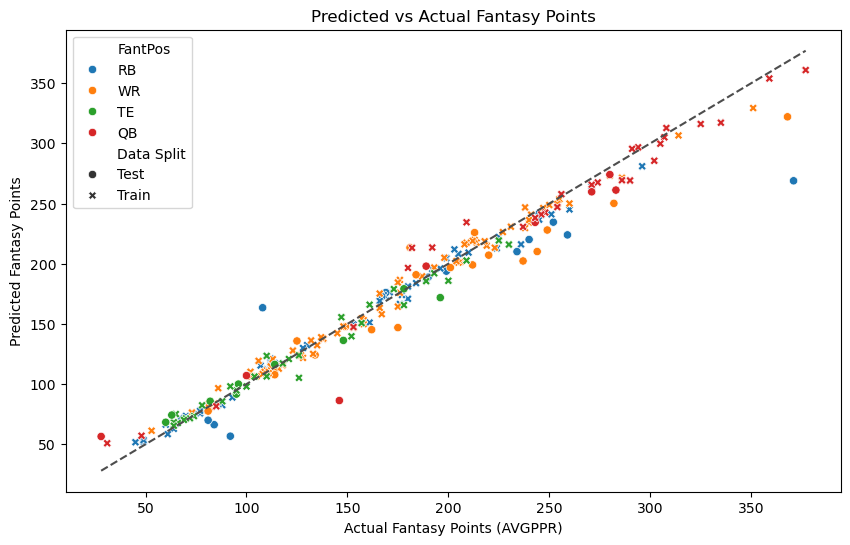

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
# Chart for the Train, Test Split Data
# Scatter plot of predicted vs actual points for all positions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_predictions, x='AVGPPR', y='Predicted Fantasy Points', hue='FantPos', style='Data Split')
plt.plot([all_predictions['AVGPPR'].min(), all_predictions['AVGPPR'].max()],
         [all_predictions['AVGPPR'].min(), all_predictions['AVGPPR'].max()],
         ls="--", c=".3")
plt.title('Predicted vs Actual Fantasy Points')
plt.xlabel('Actual Fantasy Points (AVGPPR)')
plt.ylabel('Predicted Fantasy Points')
plt.show()

## Now we will use Cross Validation to determine the fantasy football projected scores.

In [34]:
# Function to train and predict for a specific position using cross-validation
def train_and_predict_cv(position, features, cv=5):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features]
    y = position_data['AVGPPR']

    # Fill missing values with 0 for simplicity
    X = X.fillna(0)
    y = y.fillna(0)

    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)

    # Create a cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Define the scoring method
    mae_scorer = make_scorer(mean_absolute_error)

    # Perform cross-validation
    cv_scores = cross_val_score(rf, X, y, cv=kf, scoring=mae_scorer)

    # Fit the model on the entire dataset after cross-validation
    rf.fit(X, y)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = rf.predict(X)

    # Calculate the mean MAE from cross-validation
    mean_cv_score = cv_scores.mean()
    print(f"\n{position} - Mean CV MAE: {mean_cv_score}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    return position_data[['Player', 'FantPos', 'Predicted Fantasy Points', 'AVGPPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023Age', '2024Age', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
wr_features = ['2023Age', '2024Age', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
te_features = ['2023Age', '2024Age', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
qb_features = ['2023Age', '2024Age', 'PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', '2024TD']

# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict_cv('RB', rb_features)
wr_predictions = train_and_predict_cv('WR', wr_features)
te_predictions = train_and_predict_cv('TE', te_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions])

# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_CV.csv"
all_predictions[['Player', 'FantPos', 'Predicted Fantasy Points', 'AVGPPR']].to_csv(output_path, index=False)


RB - Mean CV MAE: 15.171399999999997

RB - Feature Importances:
        Feature  Importance
11  2024RushAtt    0.312026
18       2024TD    0.270073
3   2023RushYds    0.148377
13   2024RushTD    0.065687
9        2023TD    0.047892
12  2024RushYds    0.045263
15   2024RecYds    0.028294
14      2024Rec    0.023748
5       2023Rec    0.015580
16    2024RecTD    0.010591
4    2023RushTD    0.009143
2   2023RushAtt    0.007586
6     2023RecTD    0.007410
0       2023Age    0.001970
1       2024Age    0.001794
7         2023G    0.001681
8        2023FL    0.001042
17       2024FL    0.000926
10        2024G    0.000915

WR - Mean CV MAE: 14.133807017543859

WR - Feature Importances:
        Feature  Importance
14      2024Rec    0.806301
5       2023Rec    0.053580
18       2024TD    0.035797
15   2024RecYds    0.029057
16    2024RecTD    0.024841
9        2023TD    0.010163
6     2023RecTD    0.008343
3   2023RushYds    0.005660
2   2023RushAtt    0.005242
12  2024RushYds    0.004666
7 

## Function to train and predict for a specific position using RandomizedSearchCV

In [20]:
# Function to train and predict for a specific position using RandomizedSearchCV
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features]
    y = position_data['AVGPPR']

    # Fill missing values with 0 for simplicity
    X = X.fillna(0)
    y = y.fillna(0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Add labels to indicate training or testing data
    position_data.loc[X_train.index, 'Data Split'] = 'Train'
    position_data.loc[X_test.index, 'Data Split'] = 'Test'

    # Define the parameter grid
    param_distributions = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    # Set up the RandomForestRegressor model
    rf = RandomForestRegressor(random_state=42)

    # Set up RandomizedSearchCV
    rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                          n_iter=30, cv=3, verbose=2, random_state=42, n_jobs=-1)
    
    # Train the model with RandomizedSearchCV
    rf_random_search.fit(X_train, y_train)

    # Get the best model from the search
    best_rf = rf_random_search.best_estimator_

    # Evaluate the model
    y_pred_train = best_rf.predict(X_train)
    y_pred_test = best_rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = best_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = best_rf.predict(X)

    # Round up the 'Predicted Fantasy Points'
    position_data['Predicted Fantasy Points'] = np.ceil(position_data['Predicted Fantasy Points'])
    
    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', 'AVGPPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023Age', '2024Age', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
wr_features = ['2023Age', '2024Age', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
te_features = ['2023Age', '2024Age', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024TD']
qb_features = ['2023Age', '2024Age', 'PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', '2024TD']

# Train and predict for each position
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions])

# Save the projected data to a new CSV file
output_path = "Data/CombinedFantasyFootballPrediction_RSCV.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', 'AVGPPR']].to_csv(output_path, index=False)

Fitting 3 folds for each of 30 candidates, totalling 90 fits

RB - Training MAE: 4.480071428571429
RB - Testing MAE: 20.634348148148145

RB - Feature Importances:
        Feature  Importance
18       2024TD    0.147022
11  2024RushAtt    0.137493
13   2024RushTD    0.127885
3   2023RushYds    0.105980
14      2024Rec    0.100368
15   2024RecYds    0.086318
9        2023TD    0.061759
4    2023RushTD    0.061749
2   2023RushAtt    0.051096
12  2024RushYds    0.034462
5       2023Rec    0.026713
16    2024RecTD    0.019496
7         2023G    0.010638
6     2023RecTD    0.009173
1       2024Age    0.005537
0       2023Age    0.005168
8        2023FL    0.004942
10        2024G    0.002300
17       2024FL    0.001900
Fitting 3 folds for each of 30 candidates, totalling 90 fits

WR - Training MAE: 4.7581981981981984
WR - Testing MAE: 17.402877192982448

WR - Feature Importances:
        Feature  Importance
14      2024Rec    0.840696
5       2023Rec    0.039235
18       2024TD    0.035101
1

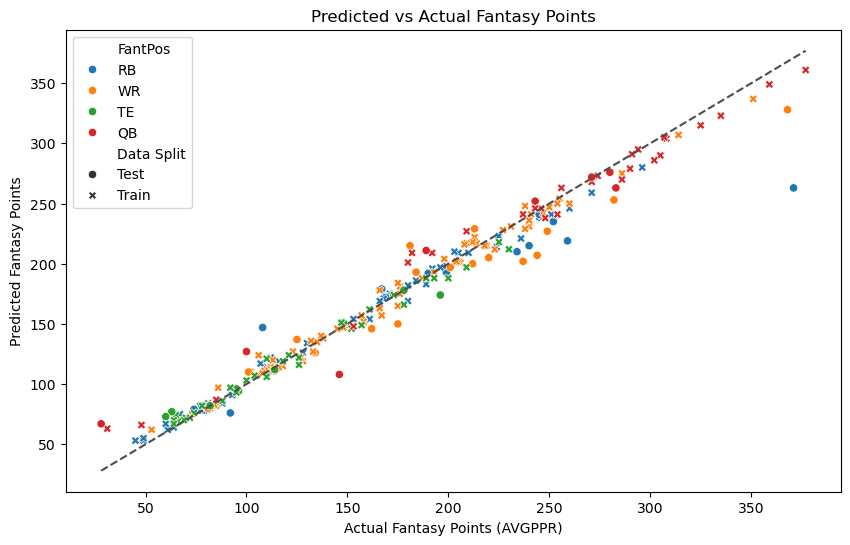

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of predicted vs actual points for all positions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_predictions, x='AVGPPR', y='Predicted Fantasy Points', hue='FantPos', style='Data Split')
plt.plot([all_predictions['AVGPPR'].min(), all_predictions['AVGPPR'].max()],
         [all_predictions['AVGPPR'].min(), all_predictions['AVGPPR'].max()],
         ls="--", c=".3")
plt.title('Predicted vs Actual Fantasy Points')
plt.xlabel('Actual Fantasy Points (AVGPPR)')
plt.ylabel('Predicted Fantasy Points')
plt.show()